# Loading Data Using Herbie
See Herbie documentation: [Herbie](https://herbie.readthedocs.io/en/2024.3.0/user_guide/install.html)


In [29]:
from herbie import Herbie
import matplotlib.pyplot as plt
from cartopy import feature as cfeature
import csv
import pandas as pd
import xarray
from herbie.toolbox import EasyMap, pc
import os


In [2]:
import requests

response = requests.get("https://www.amazon.com/", verify=False)

H = Herbie(
    "2021-07-19",
    model="hrrr",
    product="sfc",
    fxx=0,
)
ds_u = H.xarray(':UGRD:10 m')
ds_v = H.xarray(':VGRD:10 m')
ds_p = H.xarray(':PRES:surface')


ds_u = ds_u.assign_coords(
    longitude=(((ds_u.longitude + 180) % 360) - 180)
)
ds_v = ds_v.assign_coords(
    longitude=(((ds_v.longitude + 180) % 360) - 180)
)

ds_p = ds_p.assign_coords(
    longitude=(((ds_p.longitude + 180) % 360) - 180)
)


# Define the bounding box
north_bound = 90  # northern latitude
south_bound = 20  # southern latitude
east_bound  = -50 # eastern longitude
west_bound  = -95# western longitude

# Subset the dataset by applying a filter on latitude and longitude using xarray's where()
subset_u = ds_u.where(
    (ds_u.latitude >= south_bound) & (ds_u.latitude <= north_bound) &
    (ds_u.longitude >= west_bound) & (ds_u.longitude <= east_bound),
    drop=True
)

subset_v = ds_v.where(
    (ds_v.latitude >= south_bound) & (ds_v.latitude <= north_bound) &
    (ds_v.longitude >= west_bound) & (ds_v.longitude <= east_bound),
    drop=True
)

subset_p = ds_p.where(
    (ds_p.latitude >= south_bound) & (ds_p.latitude <= north_bound) &
    (ds_p.longitude >= west_bound) & (ds_p.longitude <= east_bound),
    drop=True
)

ds = xarray.merge([subset_u, subset_v, subset_p])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

In [3]:
H.PRODUCTS

{'sfc': '2D surface level fields; 3-km resolution',
 'prs': '3D pressure level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [4]:
# Gather latitude and longitude values for each hurricane track
points = []
currHur = ''
hur = {'latitude': [], 'longitude': [], 'time': []}
with open('filtered_data.csv', 'r') as f_in:
    reader = csv.reader(f_in)
    next(reader)
    for line in reader:
        while len(line[4]) < 4: line[4] = '0' + line[4]
        if currHur != line[0]:
            currHur = line[0]
            currTime = pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M')

            points.append(pd.DataFrame(hur))
            hur = {
                'latitude': [float(line[7])],
                'longitude': [float(line[8])],
                'time': [(pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour')]
                }
        else:
            hur['latitude'].append(float(line[7]))
            hur['longitude'].append(float(line[8]))
            hur['time'].append((pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M') - currTime)/pd.Timedelta('1 hour'))

points.pop(0)
points[0]

,latitude,longitude,time
0,22.7,-72.5,0.0
1,24.1,-73.1,6.0
2,25.4,-73.5,12.0
3,26.8,-73.6,18.0
4,28.5,-73.6,24.0
5,30.5,-73.4,30.0
6,32.5,-73.2,36.0
7,34.2,-72.7,42.0
8,35.5,-71.2,48.0
9,36.8,-69.3,54.0


In [5]:
dsi = ds.herbie.pick_points(
    points[0].loc[:, 'latitude':'longitude'],
    method='nearest',
)
dsi

<xarray.Dataset> Size: 620B
Dimensions:              (point: 11)
Coordinates:
    time                 datetime64[ns] 8B 2021-07-19
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 10.0
    latitude             (point) float64 88B 22.7 24.1 25.39 ... 36.79 38.1
    longitude            (point) float64 88B -72.49 -73.1 ... -69.32 -66.92
    valid_time           datetime64[ns] 8B 2021-07-19
    gribfile_projection  object 8B None
    surface              float64 8B 0.0
    point_grid_distance  (point) float64 88B 1.33 0.03443 0.994 ... 1.794 1.501
    point_latitude       (point) float64 88B 22.7 24.1 25.4 ... 35.5 36.8 38.1
    point_longitude      (point) float64 88B -72.5 -73.1 -73.5 ... -69.3 -66.9
Dimensions without coordinates: point
Data variables:
    u10                  (point) float32 44B -8.999 -8.186 ... 2.876 2.376
    v10                  (point) float32 44B -1.151 -0.9636 ... 7.786 5.849
    sp                   (point) float32 44B 1.019e+05 1.02e+05 ... 1.02e+05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/joebeyrer/data/hrrr/20210719/subset_6eeff...
    search:                  :UGRD:10 m

In [6]:
matched = []
for point in points:
    matched.append(ds.herbie.pick_points(point))

matched[0]

       latitude  longitude  time  point_grid_distance  grid_index  y_grid  \
point                                                                       
8          28.5     -101.7  42.0           584.271213      132878     158   
9          29.7     -103.3  48.0           734.495504      173246     206   

       x_grid  latitude_grid  longitude_grid  
point                                         
8           0      28.521982      -95.719777  
9           0      29.800206      -95.691234  



<xarray.Dataset> Size: 708B
Dimensions:              (point: 11)
Coordinates:
    time                 datetime64[ns] 8B 2021-07-19
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 10.0
    latitude             (point) float64 88B 22.7 24.1 25.39 ... 36.79 38.1
    longitude            (point) float64 88B -72.49 -73.1 ... -69.32 -66.92
    valid_time           datetime64[ns] 8B 2021-07-19
    gribfile_projection  object 8B None
    surface              float64 8B 0.0
    point_grid_distance  (point) float64 88B 1.33 0.03443 0.994 ... 1.794 1.501
    point_latitude       (point) float64 88B 22.7 24.1 25.4 ... 35.5 36.8 38.1
    point_longitude      (point) float64 88B -72.5 -73.1 -73.5 ... -69.3 -66.9
    point_time           (point) float64 88B 0.0 6.0 12.0 ... 48.0 54.0 60.0
Dimensions without coordinates: point
Data variables:
    u10                  (point) float32 44B -8.999 -8.186 ... 2.876 2.376
    v10                  (point) float32 44B -1.151 -0.9636 ... 7.786 5.849
    sp                   (point) float32 44B 1.019e+05 1.02e+05 ... 1.02e+05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/joebeyrer/data/hrrr/20210719/subset_6eeff...
    search:                  :UGRD:10 m

In [7]:
for i in range(len(matched)):
    matched[i] = matched[i].swap_dims({"point": "point_time"})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


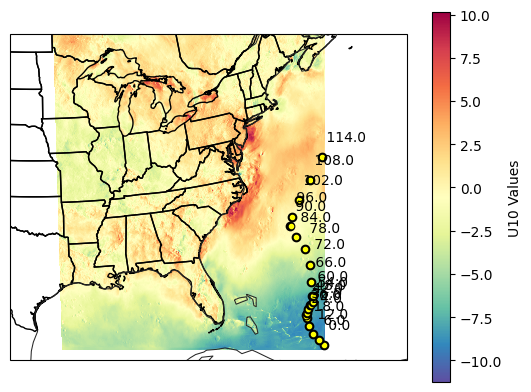

In [8]:
ax = EasyMap(crs=ds.herbie.crs).ax

c = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.u10,
    cmap="Spectral_r",
    transform=pc,
)

for i in matched[1].point_time:
    z = matched[1].sel(point_time=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_time.item()}\n",
        transform=pc,
    )

ax.set_extent([-98, -65, 25, 45], crs=pc)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.adjust_extent()


fig = plt.gcf()  
fig.colorbar(c, ax=ax, orientation='vertical', label='U10 Values')

plt.show()



### Filtering HRRR Data Based on Datetime, Latitude, and Longitude

In [9]:
df = pd.read_pickle('hurDict.pkl')
df

,name,time,trajectory,vmax,pres,34,50,64,rmax
AL032014,BERTHA,"[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0,...","[[22.7, -72.5], [24.1, -73.1], [25.4, -73.5], ...","[45.0, 55.0, 60.0, 70.0, 70.0, 65.0, 55.0, 50....","[1012.0, 1007.0, 1004.0, 998.0, 999.0, 1001.0,...","[[140.0, 100.0, 0.0, 50.0], [140.0, 100.0, 0.0...","[[0.0, 0.0, 0.0, 0.0], [40.0, 40.0, 0.0, 0.0],...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
AL042014,CRISTOBAL,"[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0,...","[[21.5, -72.2], [22.0, -72.5], [22.6, -72.9], ...","[30.0, 30.0, 35.0, 40.0, 45.0, 45.0, 45.0, 50....","[1005.0, 1004.0, 1002.0, 1001.0, 1001.0, 998.0...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
AL012015,ANA,"[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0,...","[[26.8, -79.2], [28.2, -78.5], [29.7, -77.8], ...","[25.0, 25.0, 25.0, 30.0, 35.0, 40.0, 40.0, 40....","[1016.0, 1015.0, 1014.0, 1012.0, 1010.0, 1008....","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
AL022015,BILL,"[0.0, 6.0, 12.0, 16.75, 18.0, 24.0, 30.0, 36.0...","[[27.0, -94.3], [27.6, -95.2], [28.0, -96.0], ...","[45.0, 45.0, 50.0, 50.0, 50.0, 40.0, 30.0, 30....","[1005.0, 1001.0, 997.0, 997.0, 997.0, 998.0, 9...","[[140.0, 130.0, 0.0, 0.0], [130.0, 130.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
AL032015,CLAUDETTE,"[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0]","[[35.4, -75.4], [35.3, -74.6], [35.2, -73.6], ...","[25.0, 25.0, 25.0, 25.0, 25.0, 30.0, 40.0, 45.0]","[1010.0, 1010.0, 1010.0, 1010.0, 1010.0, 1008....","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[nan, nan, nan, nan, nan, nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...
AL082023,FRANKLIN,"[0.0, 6.0, 12.0, 18.0, 24.0, 30.0, 36.0, 42.0,...","[[26.7, -70.6], [27.5, -70.9], [28.2, -71.1], ...","[100.0, 125.0, 125.0, 130.0, 120.0, 115.0, 110...","[951.0, 937.0, 931.0, 926.0, 935.0, 941.0, 947...","[[130.0, 110.0, 100.0, 80.0], [130.0, 110.0, 1...","[[50.0, 40.0, 30.0, 40.0], [60.0, 40.0, 40.0, ...","[[25.0, 20.0, 10.0, 20.0], [30.0, 20.0, 20.0, ...","[10.0, 10.0, 10.0, 5.0, 5.0, 20.0, 20.0, 25.0,..."
AL092023,HAROLD,"[0.0, 6.0, 12.0, 18.0, 24.0, 27.0, 30.0, 36.0,...","[[24.7, -89.2], [25.0, -90.8], [25.4, -92.4], ...","[25.0, 30.0, 30.0, 40.0, 50.0, 50.0, 40.0, 30....","[1008.0, 1008.0, 1008.0, 1003.0, 996.0, 995.0,...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[90.0, 90.0, 70.0, 50.0, 30.0, 30.0, 30.0, 40...."
AL102023,IDALIA,"[0.0, 6.0, 12.0, 18.0, 21.0, 23.75, 24.0, 30.0...","[[23.8, -84.8], [25.3, -84.8], [26.9, -84.7], ...","[70.0, 80.0, 90.0, 105.0, 115.0, 100.0, 100.0,...","[978.0, 973.0, 965.0, 945.0, 942.0, 950.0, 954...","[[120.0, 140.0, 50.0, 60.0], [120.0, 140.0, 50...","[[50.0, 40.0, 20.0, 30.0], [50.0, 40.0, 20.0, ...","[[20.0, 15.0, 0.0, 10.0], [20.0, 15.0, 10.0, 1...","[15.0, 15.0, 10.0, 10.0, 10.0, 10.0, 10.0, 20...."
AL132023,LEE,"[0.0, 6.0, 12.0, 18.0, 24.0, 26.0, 30.0, 36.0,...","[[37.1, -66.7], [38.7, -65.9], [40.9, -66.0], ...","[75.0, 75.0, 70.0, 65.0, 55.0, 55.0, 55.0, 50....","[962.0, 963.0, 965.0, 965.0, 968.0, 970.0, 979...","[[270.0, 270.0, 240.0, 300.0], [300.0, 300.0, ...","[[160.0, 170.0, 120.0, 150.0], [180.0, 180.0, ...","[[90.0, 80.0, 70.0, 100.0], [90.0, 120.0, 110....","[75.0, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0..."


In [46]:
class HurricanePath():
    def __init__(self, dateTime, minLat, maxLat, minLon, maxLon):
        self.dateTime = dateTime
        self.minLat = minLat
        self.maxLat = maxLat
        self.minLon = minLon
        self.maxLon = maxLon
    
    def update(self, dateTime, latMinus, latPlus, lonMinus, lonPlus):
        self.dateTime.append(dateTime)

        if self.minLat > latMinus:
            self.minLat = latMinus
        elif self.maxLat < latPlus:
            self.maxLat = latPlus
            
        if self.minLon > lonMinus:
            self.minLon = lonMinus
        elif self.maxLon < lonPlus:
            self.maxLon = lonPlus

In [47]:
# Creating a dictionary - one key for each hurricane - alternate hurDictset
paths = {}
margin = 3

with open('filtered_data.csv', 'r') as f_in:
    reader = csv.reader(f_in)
    next(reader)
    for line in reader:
        if line[0] not in paths.keys():
            while len(line[4]) < 4: line[4] = '0' + line[4]
            paths[line[0]] = HurricanePath([pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M')], float(line[7])-margin, float(line[7])+margin, float(line[8])-margin, float(line[8])+margin)
            
        else:
            while len(line[4]) < 4: line[4] = '0' + line[4]
            paths[line[0]].update(pd.to_datetime(line[3] + line[4],format='%Y%m%d%H%M'), float(line[7])-margin, float(line[7])+margin, float(line[8])-margin, float(line[8])+margin)
paths['AL032014'].dateTime

[Timestamp('2014-08-03 18:00:00'),
 Timestamp('2014-08-04 00:00:00'),
 Timestamp('2014-08-04 06:00:00'),
 Timestamp('2014-08-04 12:00:00'),
 Timestamp('2014-08-04 18:00:00'),
 Timestamp('2014-08-05 00:00:00'),
 Timestamp('2014-08-05 06:00:00'),
 Timestamp('2014-08-05 12:00:00'),
 Timestamp('2014-08-05 18:00:00'),
 Timestamp('2014-08-06 00:00:00'),
 Timestamp('2014-08-06 06:00:00')]

In [12]:
# import requests

# response = requests.get("https://www.amazon.com/", verify=False)

# herbies = {}
# for key in paths.keys():
#     herbie = []
#     dsVals = []
#     for date in paths[key].dateTime:
#         try:
#             H = Herbie(
#                 f"{date}",
#                 model="hrrr",
#                 product="sfc",
#                 fxx=0,
#             )
#             ds_u = H.xarray(':UGRD:10 m')
#             ds_v = H.xarray(':VGRD:10 m')
#             ds_p = H.xarray(':PRES:surface')\
            
#             ds_u = ds_u.assign_coords(
#                 longitude=(((ds_u.longitude + 180) % 360) - 180)
#             )
#             ds_v = ds_v.assign_coords(
#                 longitude=(((ds_v.longitude + 180) % 360) - 180)
#             )

#             ds_p = ds_p.assign_coords(
#                 longitude=(((ds_p.longitude + 180) % 360) - 180)
#             )

#             north_bound = paths[key].maxLat
#             south_bound =paths[key].minLat
#             east_bound  = paths[key].maxLon
#             west_bound  = paths[key].minLon

#             # Subset the dataset by applying a filter on latitude and longitude using xarray's where()
#             subset_u = ds_u.where(
#                 (ds_u.latitude >= south_bound) & (ds_u.latitude <= north_bound) &
#                 (ds_u.longitude >= west_bound) & (ds_u.longitude <= east_bound),
#                 drop=True
#             )

#             subset_v = ds_v.where(
#                 (ds_v.latitude >= south_bound) & (ds_v.latitude <= north_bound) &
#                 (ds_v.longitude >= west_bound) & (ds_v.longitude <= east_bound),
#                 drop=True
#             )

#             subset_p = ds_p.where(
#                 (ds_p.latitude >= south_bound) & (ds_p.latitude <= north_bound) &
#                 (ds_p.longitude >= west_bound) & (ds_p.longitude <= east_bound),
#                 drop=True
#             )

#             ds = xarray.merge([subset_u, subset_v, subset_p])
#             herbie.append(H)
#             dsVals.append(ds)
#         except:
#             continue

#         herbies[key] = [herbie, dsVals]


# herbies['AL032014']

# Example Dataset Save/Load from HRRR

In [48]:
herbies = {}
dates = []
dsVals = []
key = 'AL032014'
for date in paths[key].dateTime:
    try:
        H = Herbie(
            f"{date}",
            model="hrrr",
            product="sfc",
            fxx=0,
        )
        ds_u = H.xarray(':UGRD:10 m')
        ds_v = H.xarray(':VGRD:10 m')
        ds_p = H.xarray(':PRES:surface')\
        
        ds_u = ds_u.assign_coords(
            longitude=(((ds_u.longitude + 180) % 360) - 180)
        )
        ds_v = ds_v.assign_coords(
            longitude=(((ds_v.longitude + 180) % 360) - 180)
        )

        ds_p = ds_p.assign_coords(
            longitude=(((ds_p.longitude + 180) % 360) - 180)
        )

        north_bound = paths[key].maxLat
        south_bound =paths[key].minLat
        east_bound  = paths[key].maxLon
        west_bound  = paths[key].minLon

        # Subset the dataset by applying a filter on latitude and longitude using xarray's where()
        subset_u = ds_u.where(
            (ds_u.latitude >= south_bound) & (ds_u.latitude <= north_bound) &
            (ds_u.longitude >= west_bound) & (ds_u.longitude <= east_bound),
            drop=True
        )

        subset_v = ds_v.where(
            (ds_v.latitude >= south_bound) & (ds_v.latitude <= north_bound) &
            (ds_v.longitude >= west_bound) & (ds_v.longitude <= east_bound),
            drop=True
        )

        subset_p = ds_p.where(
            (ds_p.latitude >= south_bound) & (ds_p.latitude <= north_bound) &
            (ds_p.longitude >= west_bound) & (ds_p.longitude <= east_bound),
            drop=True
        )

        ds = xarray.merge([subset_u, subset_v, subset_p])
        dates.append(date)
        dsVals.append(ds)
    except:
        continue

    herbies[key] = [dates, dsVals]


herbies[key]

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-03 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

💔 Did not find ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-04 00:00 UTC F00
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-04 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-04 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-04 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-05 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-05 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

💔 Did not find ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-05 18:00 UTC F00
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2014-Aug-06 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta

[[Timestamp('2014-08-03 18:00:00'),
  Timestamp('2014-08-04 06:00:00'),
  Timestamp('2014-08-04 12:00:00'),
  Timestamp('2014-08-04 18:00:00'),
  Timestamp('2014-08-05 00:00:00'),
  Timestamp('2014-08-05 06:00:00'),
  Timestamp('2014-08-05 12:00:00'),
  Timestamp('2014-08-06 00:00:00'),
  Timestamp('2014-08-06 06:00:00')],
 [<xarray.Dataset> Size: 7MB
  Dimensions:              (y: 788, x: 320)
  Coordinates:
      time                 datetime64[ns] 8B 2014-08-03T18:00:00
      step                 timedelta64[ns] 8B 00:00:00
      heightAboveGround    float64 8B 10.0
      latitude             (y, x) float64 2MB 23.0 23.0 22.99 ... 41.1 41.1 41.09
      longitude            (y, x) float64 2MB -81.0 -80.97 -80.94 ... -64.7 -64.67
      valid_time           datetime64[ns] 8B 2014-08-03T18:00:00
      gribfile_projection  object 8B None
      surface              float64 8B 0.0
  Dimensions without coordinates: y, x
  Data variables:
      u10                  (y, x) float32 1MB nan nan

In [49]:
cwd = os.getcwd()
os.makedirs(f'{cwd}/data/filtered_HRRR', exist_ok=True)

for i in range(len(herbies[key][1])):
    ds = herbies[key][1][i]
    ds.to_netcdf(f'{cwd}/data/filtered_HRRR/{dates[i].strftime("%m-%d-%Y-%H:%M")}_data', 'w')

In [50]:
import xarray as xr
ds = xr.open_dataset(f'{cwd}/data/filtered_HRRR/08-03-2014-18:00_data')
ds

/var/folders/rt/c2m6bx6n12j282w1_l6qv5l00000gn/T/ipykernel_54003/3902053209.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(f'{cwd}/data/filtered_HRRR/08-03-2014-18:00_data')


<xarray.Dataset> Size: 7MB
Dimensions:              (y: 788, x: 320)
Coordinates:
    latitude             (y, x) float64 2MB ...
    longitude            (y, x) float64 2MB ...
    time                 datetime64[ns] 8B ...
    step                 timedelta64[ns] 8B ...
    heightAboveGround    float64 8B ...
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  float64 8B ...
    surface              float64 8B ...
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 1MB ...
    v10                  (y, x) float32 1MB ...
    sp                   (y, x) float32 1MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/joebeyrer/data/hrrr/20140803/subset_a6efd...
    search:                  :UGRD:10 m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


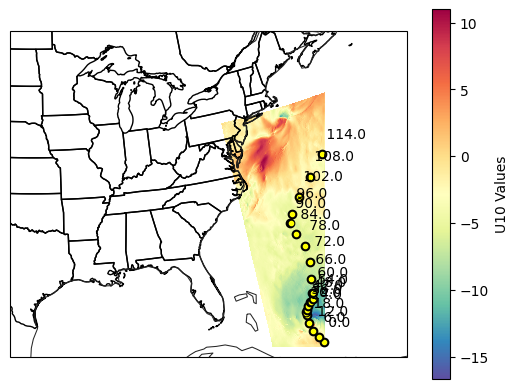

In [ ]:
ax = EasyMap(crs=ds.herbie.crs).ax

c = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.u10,
    cmap="Spectral_r",
    transform=pc,
)

for i in matched[1].point_time:
    z = matched[1].sel(point_time=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_time.item()}\n",
        transform=pc,
    )

ax.set_extent([-98, -65, 25, 45], crs=pc)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.adjust_extent()


fig = plt.gcf()  
fig.colorbar(c, ax=ax, orientation='vertical', label='U10 Values')

plt.show()
